In [127]:
import numpy as np
import pandas as pd
import csv
from numpy import linspace,exp
from numpy.random import randn
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import seaborn as sns

import scipy 
import editdistance
import sklearn.metrics
import statsmodels.api as sm
from hmmlearn import hmm


%matplotlib inline 

This notebook requires cpython code from https://github.com/aky4wn/Classical-Music-Composition-Using-State-Space-Models/tree/master/Code. See instructions in Readme file.


In [128]:
np.get_include()

'/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/include'

In [129]:
## Helper functions for working with note pitch representation

## Convert from pitch representation (integers 0-127) to integers (0-max)
## x is the input vector of notes and code is a vector of the unique pitches in x
def encode(x, code):
    output = np.array([int(np.where(code == x[i])[0]) for i in range(0, len(x))])
    return output


## Reverses the function encode
## x is the vector of pitches to decode and code is a vector of the unique pitches in x before it was encoded
def decode(x, code):
    output = np.zeros(len(x))
    for i in range(0, len(x)):
        output[i] = code[x[i]]
    return output

## Function to convert the values in array to the nearest values in the array value
## Used to convert continues TVAR generated pitches to closest integer values for MIDI representation
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

In [130]:
## Function to pre-process input CSV of original song into form that can be used for modeling and metrics
## Assumes original piece's MIDI file has been converted to a CSV using http://www.fourmilab.ch/webtools/midicsv/#midicsv.5
## input_filename = name of original csv
## output_filename = name of new csv to save generated piece to
## Outputs:
##         quarter_note = number of time steps corresponding to 1 quarter note
##         num = numerator in key signature
##         denom = denominator in key signature
##         key = key signature of piece, integer between -7 and 7 where 0 is C Major
##         measures = number of measures in input piece
##         time = vector of time stamps at which notes occurr
##         notes = vector of note pitches (integers 0-127)
##         velocity = "volume" of each note pitch, 0 = note off, length of time is the same as length of notes and velocity
##         song = pandas dataframe to use for output generated pieces, retains formatting expected by MIDI-CSV
##         song.index = index of original song dataframe

## See http://www.fourmilab.ch/webtools/midicsv/#midicsv.5 for a discussion of MIDI and CSV formats

class pre_process(object):
    def __init__(self, input_filename, min_note):
        self.input_filename = input_filename
        self.min_note = min_note
      
    
    def read_process(self):
        with open(self.input_filename,encoding = "ISO-8859-1") as fd:
            reader=csv.reader(fd)
            rows= [row for idx, row in enumerate(reader)]
        song = pd.DataFrame(rows)
        r,c = np.where(song == ' Header')
        quarter_note = song.iloc[r,5].values.astype(int)[0]
        r, c = np.where(song == ' Time_signature')
        num = song.iloc[r, 3].values.astype(int)[0]
        denom = song.iloc[r, 4].values.astype(int)[0]**2
        try:
            r, c = np.where(song == ' Key_signature')
            key = song.iloc[r,3].values.astype(int)[0]
        except:
            key = None
        
        song_model = song.loc[song.iloc[:,0] == np.max(song.iloc[:,0])]
        song_model = song_model[song_model.iloc[:, 2].isin([' Note_on_c', ' Note_off_c'])]
        time = np.array(song_model.iloc[:,1]).astype(int)
        notes = np.array(song_model.iloc[:,4]).astype(int)
        velocity = np.array(song_model.iloc[:,5]).astype(int)
        measures = np.round(np.max(time)/quarter_note)/num
        min_note = quarter_note
        actual = np.arange(0, min_note*measures*num, min_note).astype(int) 
        time = np.array([find_nearest(actual, time[i]) for i in range(len(time))]).astype(int)
        return(quarter_note, num, denom, key, measures, time, notes, velocity, song, song_model.index)

# Functions for Interpolating Velocity

In [131]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel,ExpSineSquared
## newNotes = vector of note pitches of new, generated piece
## velocity = velocity of original piece
## newVelocities = velocities for newNotes, with 0s appropriately filled in and spline values for other non-0 values
def plot_gp(x_pred, y_pred, sigmas, x_train, y_train, true_y=None, samples=None):
    """
    Function that plots the GP mean & std on top of given points.
    x_pred: points for prediction
    y_pred: means
    sigmas: std
    x, y: given data
    true_y: 
    samples: 2D numpy array with shape (# of points, # of samples)
    """
    if samples is not None:
        plt.plot(all_x.reshape(-1, 1), samples)
    
    plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0, 
                 ecolor=(0.85, 0.85, 0.85), fmt = "r-", 
                 label="pred mean")
    plt.plot(x_train, y_train, "ko", label="training set")
    if true_y is not None:
        plt.plot(x_pred, true_y, "b-", label="truth function")
    plt.legend()


def find_vel(newNotes, velocity,gp):
    # Use splines to interpolate the velocities
    newVelocities = np.zeros(len(newNotes))
    y = velocity[np.nonzero(velocity)] # all the nonzero elements need to be interpolated
    indicies = []
    for i in np.unique(newNotes):
        indicies.append(np.where(newNotes == i)[0][::2])  ## set every other pitch occurrence to 0 (turn off)
   
    unlist = [item for sublist in indicies for item in sublist]
    unlist.sort()
    
    if gp :
        kernel = RBF(length_scale=0.2) + ConstantKernel(constant_value=1, constant_value_bounds=(1e-5, 1e5))
        gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
        X = np.asarray(np.flatnonzero(velocity))

        gp.fit(X.reshape(-1,1), y.reshape(-1,1))
        all_x = np.asarray(unlist)
        mus, sigmas = gp.predict(all_x.reshape(-1,1), return_std=True)
#         plt.figure()
#         plot_gp(all_x, mus, sigmas, X, y, true_y=None)
#         plt.show()
        newVelocities[np.array(unlist)] = np.round(mus.reshape(-1,)).astype(int)
        #newVelocities[np.where(newVelocities < 0)[0]] = y[-1]
        newVelocities = newVelocities.astype(int) 
#         print(newVelocities)

        
    else:
        X = np.array(range(0,len(y)))
        s = UnivariateSpline(X, y, s=300) #750
        xs = np.linspace(0, len(y), len(unlist), endpoint = True)
        ys = s(xs)   
        newVelocities[np.array(unlist)] = np.round(ys).astype(int)
        #Fix entries that are too small or too large due to spline overfitting
        newVelocities[np.where(newVelocities < 0)[0]] = y[-1]
        #print(y[-1])
        newVelocities = newVelocities.astype(int) 
    
    
    return(newVelocities)

In [132]:
## Function to generate new pieces from the HMM, 2-HMM, 3-HMM, LR-HMM, 2LR-HMM, and 3-LR HMM
## n is the length of the original and generated piece
## pi is the learned initial distribution
## phi is the learned emission distribution
## Tmat is the learned transition matrix
## T2mat is the learned second order transition matrix (if applicable)
## T3mat is the learned third order transition matrix (if applicable)
## code is the unique note pitches occurring in the original piece
## model is the model order which the input parameters correspond to, either "first_order", "second_order" or "third_order"
## Outputs: output is the note pitches of the generated pieces (array of length n), z are the generated hidden states 
##          (vector of length n)
def sample_hmm(n, pi, phi, Tmat, T2mat, T3mat, code, model):
    m = Tmat.shape[0]
    k = phi.shape[1]
    zstates = np.arange(0, m, dtype = int)
    xstates = np.arange(0, k, dtype = int)
    z = np.zeros(n, dtype = int)
    x = np.zeros(n, dtype = int)
    z[0] = np.random.choice(zstates, size = 1, p = pi)
    if model == 'first_order':
        for j in range(1, n):
            z[j] = np.random.choice(zstates, size = 1, p = Tmat[z[j-1], :])
        for i in range(0, n):
            x[i] = np.random.choice(xstates, size = 1, p = phi[z[i], :])
     
    if model == 'second_order':
        z[1] = np.random.choice(zstates, size = 1,  p = Tmat[z[0], :])
        for j in range(2, n):
            z[j] = np.random.choice(zstates, size = 1,  p = T2mat[z[j-2],z[j-1], :])
        for i in range(0, n):
            x[i] = np.random.choice(xstates, size =1, p = phi[z[i], :])
    if model == 'third_order':
        z[1] = np.random.choice(zstates, size = 1,  p = Tmat[z[0], :])
        z[2] = np.random.choice(zstates, size = 1,  p = T2mat[z[0],z[1], :])
        for j in range(3, n):
            z[j] = np.random.choice(zstates, size = 1,  p = T3mat[z[j-3],z[j-2],z[j-1], :])
        for i in range(0, n):
            x[i] = np.random.choice(xstates, size =1, p = phi[z[i], :])
    output = decode(x, code)
    return (output, z)


# Functions for Evaluation 

In [133]:
from statsmodels.tsa.stattools import acf, ccf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Function to create a matrix of notes and times representing the input piece as a matrix
## time is the time steps (integers) at which a note occurs
## notes are the note pitches (integers 0-127) where each note is "turned on" and "turned off"
## velocity is the note velocity (i.e. volume) at each time step
## measures is the number measures in the original piece
## min_note is the length of the shortest note in the original piece, using same scale as time array above
## num is the number of quarter notes in a measure (i.e. represents the numerator of time signature of the input piece)
## met_mat output is a matrix where columns correspond to the time stamp of notes, one column for each min_note
##    duration for the entire piece and the rows are the note pitches, values in the matrix are 1 for the duration
##    of a note when it is played and 0 when it is not played
def create_matrix(time, notes, velocity, measures, min_note, num):
    met_mat = pd.DataFrame(np.zeros(shape = (len(np.unique(notes)), int(measures)*num), dtype = int))
    met_mat.index = np.unique(notes)[::-1]
    met_mat.columns = np.arange(0, min_note*num*measures, min_note)[:int(measures)*num]
    #print(met_mat.columns)
    max_time = met_mat.columns[-1]
    #print(max_time)
    for i in np.unique(notes):
        #print('i',i)
        on = time[np.intersect1d(np.where(notes == i), np.where(velocity > 0) )]
        #print('on',on)
        off = time[np.intersect1d(np.where(notes == i), np.where(velocity == 0) )]
        #print('off',off)
        if len(off) % 2 !=0 or len(on) %2 !=0:
            off = np.append(off, max_time)
        for j in range(len(on)):
            #print(on[j])
            #print(off[j])
            met_mat.loc[i, on[j]:off[j]] = 1
            #print(i,on[j],off[j])
    return(met_mat)

## Function to calculate the musical metrics of generated pieces
## met_mat is the output from create_matrix()
## harmonic ints is a vector of length 12 corresponding to the counts of each type of harmonic interval in the piece considered
## melodic ints is a vector of length 12 corresponding to the counts of each type of melodic interval in the piece considered
## percentage is a vector of length 6 containing the percentage of perfect harmonic intervals, the percentage of imperfect 
##           consonant harmonic intervals, the percentage of dissonant harmonic intervals, the percentage of perfect melodic
##           intervals, the percentage of imperfect consonant melodic intervals and the percentage of dissonant melodic intervals
def musical_metrics(met_mat):
    perfect = np.array([0,5,7])
    imperfect = np.array([3,4,8,9])
    dissonant = np.array([1,2,6,10,11])
    major_scale = np.array([2,2,1,2,2,2,1])
    harmonic_ints = np.zeros(12)
    c = 0
    max_notes = np.max(np.sum(met_mat, axis = 0))
    melodic = np.zeros(shape = (max_notes, len(met_mat.columns)))
    for col in met_mat.columns:
        chord = np.array(met_mat.index[np.where(met_mat[col] == 1)[0]])[::-1]
        if len(chord) > 0:
            intervals = np.diff(chord)
            intervals[intervals >= 12] = intervals[intervals >= 12] % 12
            harmonic_ints[intervals.astype(int)] +=1
            melodic[:len(chord), c] = chord
            c+= 1
    melodic_ints = list()
    for t in range(melodic.shape[1] - 1):
        m1 = melodic[melodic[:,t] > 0, t]
        m2 = melodic[melodic[:,t+1] > 0, t+1]
        melodic_ints.append(np.unique([abs(i-j) %12 for i in m1 for j in m2]))

    u = np.unique(np.hstack(melodic_ints), return_counts=True)
    m_ints = np.zeros(12)
    m_ints[u[0].astype(int)] = u[1].astype(int)

    h_total = np.sum(harmonic_ints)
    m_total = np.sum(m_ints)

    h_per = np.sum(harmonic_ints[perfect])/h_total
    h_imp = np.sum(harmonic_ints[imperfect])/h_total
    h_dis = np.sum(harmonic_ints[dissonant])/h_total

    m_per = np.sum(m_ints[perfect])/m_total
    m_imp = np.sum(m_ints[imperfect])/m_total
    m_dis = np.sum(m_ints[dissonant])/m_total

    percentage = np.array([h_per, h_imp, h_dis, m_per, m_imp, m_dis])

    return(harmonic_ints, m_ints, percentage)

## Calculate the empirical entropy of the input data and output as a vector in entropy
def ent(data):
    p_data= np.unique(data, return_counts = True)[1]/len(data) # calculates the probabilities
    entropy=scipy.stats.entropy(p_data)  # input probabilities to get the entropy 
    return entropy


## Function to compare an original piece to a generated piece and calculate metrics
## old_notes is a vector of the original piece's note pitches
## new_notes is a vector of the generated piece's note pitches
## Returns the empirical entropy, mutual information and edit distance between the original piece and the new, generated piece
##        also returns the count of unique notes in the generated piece, normalized by the total number of notes
def originality_metrics_comparison(old_notes, new_notes):
    # Calculate entropy
    entropy = ent(new_notes)

    # Calculate edit distance
    edit_dist = editdistance.eval(old_notes, new_notes)/len(old_notes)

    # Calculate mutual info
    mutual_info = sklearn.metrics.mutual_info_score(old_notes, new_notes)

    k = len(np.unique(old_notes))
    possibleNotes = np.unique(old_notes)    
    # Calculate note counts
    unique_new_notes, note_counts = np.unique(new_notes, return_counts = True)

    if len(unique_new_notes) != k:
        add_notes = list(set(possibleNotes) - set(unique_new_notes))
        for i in add_notes:
            if np.where(possibleNotes == i)[0] > len(note_counts):
                note_counts = np.append(note_counts, np.where(possibleNotes == i)[0], 0)
            else:
                note_counts = np.insert(note_counts, np.where(possibleNotes == i)[0], 0)
    note_counts = note_counts/len(old_notes)
    return(entropy, mutual_info, edit_dist, note_counts)


## Function to calculate the ACF and PACF out to lag 40
## new_ntoes is the input vector of note pitches
## note_acf is a vector of length 41 of the ACF values and note_pacf is a vector of length 41 of the PACF values
def time_metrics(new_notes):   
    #Calculate ACF/PACF out to lag 40
    note_acf = sm.tsa.stattools.acf(new_notes)
    plot_acf(new_notes,lags = 30)
    try:
        note_pacf = sm.tsa.stattools.pacf(new_notes)
    except np.linalg.linalg.LinAlgError as err:
        note_pacf = sm.tsa.stattools.pacf(new_notes)
    plot_pacf(new_notes,lags = 30)
    return(note_acf, note_pacf)


## Function to calculate all metrics
## time is the time steps (integers) at which a note occurs
## notes are the note pitches (integers 0-127) where each note is "turned on" and "turned off"
## velocity is the note velocity (i.e. volume) at each time step
## measures is the number measures in the original piece
## min_note is the length of the shortest note in the original piece, using same scale as time array above
## num is the number of quarter notes in a measure (i.e. represents the numerator of time signature of the input piece)
## output is a vector of the calculated metrics:
##        entropy is the empirical entropy of new_notes
##        mutual_info is the mutual information between old_notes and new_notes
##        edit_dist is the edit distance between old_notes and new_notes
##        harmonic_ints is a vector of length 12 of the count of harmonic intervals of each type in new_notes
##        melodic_ints is a vector of length 12 of the count of melodic intervals of each type in new_notes
##        percentage is a vector of length 6 containing the percentage of perfect harmonic intervals, the percentage of imperfect 
##           consonant harmonic intervals, the percentage of dissonant harmonic intervals, the percentage of perfect melodic
##           intervals, the percentage of imperfect consonant melodic intervals and the percentage of dissonant melodic intervals      
##       note_counts is a vector of length equal to the number of unique pitches in old_notes with a normalized count of pitches
##           in new_notes
##       note_acf is a vector of length 41 with the acf of new_notes
##       note_pacf is a vector of length 41 with the pacf of new_notes
## Note: time is the same for old_notes and new_notes, as this is not changed between the original and generated pieces
##  (likewise, measures, min_note and num are the same for old_notes and new_notes)
def calc_metrics(time, old_notes, new_notes, velocity, measures, min_note, num):
    met_mat = create_matrix(time, new_notes, velocity, measures, min_note, num)
    harmonic_ints, m_ints, percentage = musical_metrics(met_mat)
    entropy, mutual_info, edit_dist, note_counts = originality_metrics_comparison(old_notes, new_notes)
    note_acf, note_pacf = time_metrics(new_notes)
    entropy = ent(new_notes)
    return(harmonic_ints, m_ints, percentage, entropy,note_acf, note_pacf)

# Load Music Data

In [8]:
import pickle

file = open('/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/JSB_Chorales.pickle', 'rb')
dataset = pickle.load(file)
file.close()

In [9]:
len(dataset['test'])

77

In [10]:
def get_training_notes(dataset):

    notes=[]
    current_notes=[]   
    
    for piece in dataset['train']:
        for seq in piece:
            #print(seq)
            #print(current_notes)
            unwanted=[]
            for i in current_notes:
                #print('check whether in seq '+str(i))
                if i not in list(seq):
                    #print('not in:'+str(i))
                    notes.append(i)
                    #print('append:'+str(i))            
                    #current_notes.remove(i)
                    unwanted.append(i)
                    #print('removed:'+str(i))
                #print(current_notes)
            current_notes = [ele for ele in current_notes if ele not in unwanted] 

            for j in list(seq):
                if j not in current_notes:
                    notes.append(j)
                    current_notes.append(j)
    return notes      

In [11]:
tr_notes = get_training_notes(dataset)
len(tr_notes)

67034

## Get music template

In [97]:
import os
# Choose a music template
fname = '13Alleinzudir'
min_note = 1024

#load music template
dir_path = '/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/results/'
filepath = os.path.join(dir_path,fname+'.csv')
music = pre_process(filepath,min_note)

quarter_note, num, denom, key, measures, time, \
            notes_template, velocity, song, ind = music.read_process()
possibleVelocities =  np.unique(velocity)


# Intialize metrics for storing
Metrics = {}

In [98]:
possibleNotes = np.unique(tr_notes)
k = len(possibleNotes)
xNotes = encode(tr_notes, possibleNotes)
n = len(xNotes)


# HMM fitting

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


hmm10


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become 

hmm20


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/graphics/utils.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/

hmm30


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/graphics/utils.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.fra

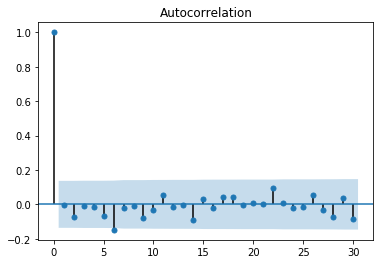

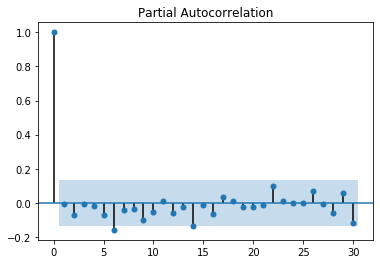

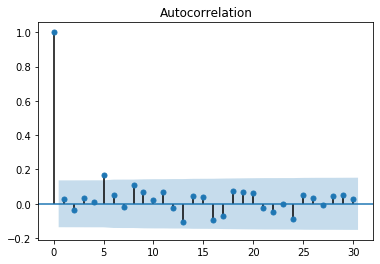

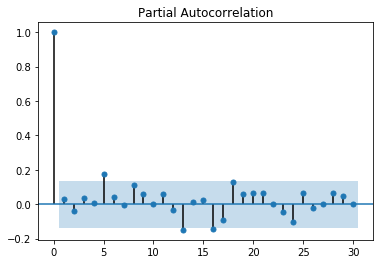

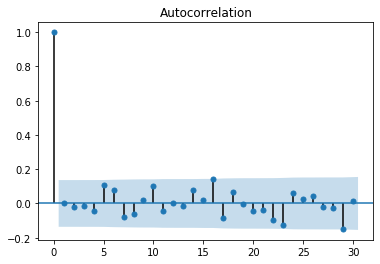

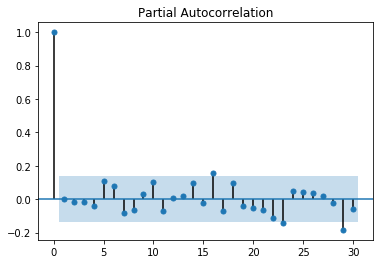

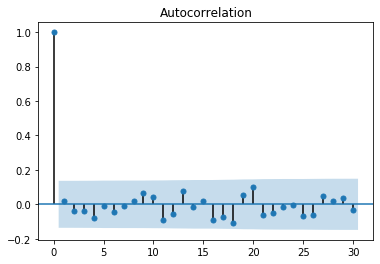

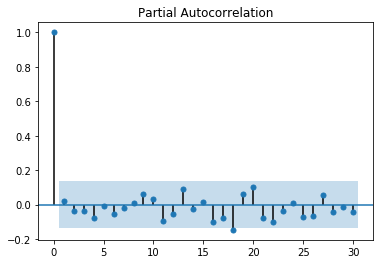

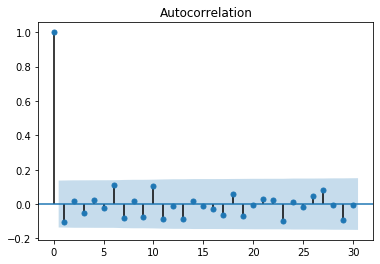

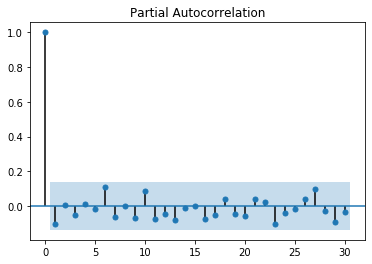

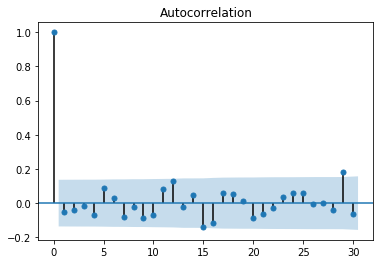

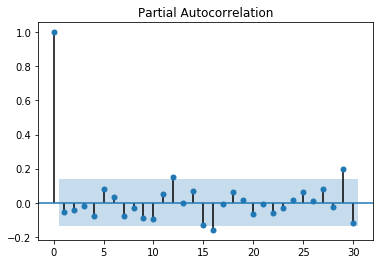

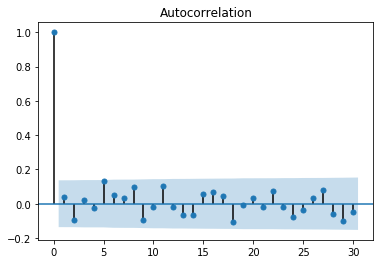

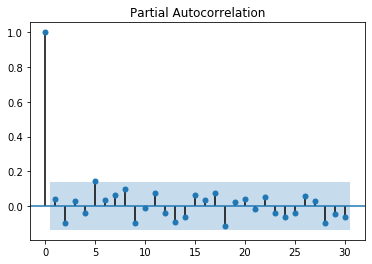

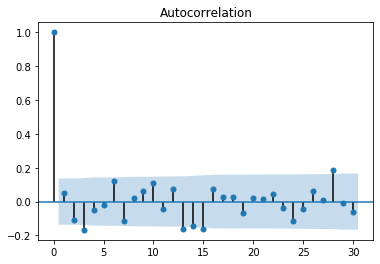

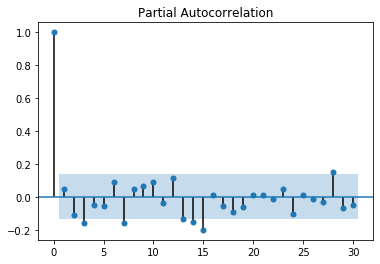

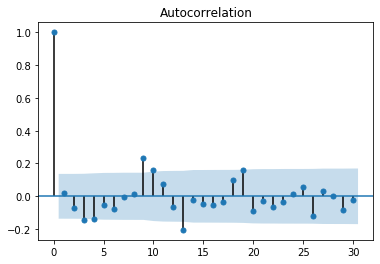

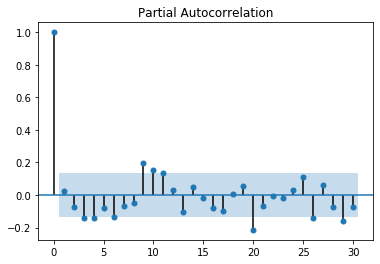

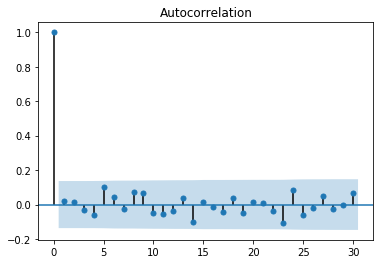

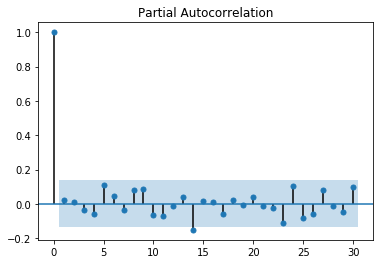

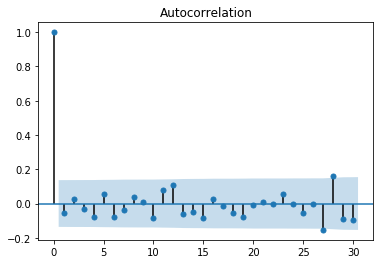

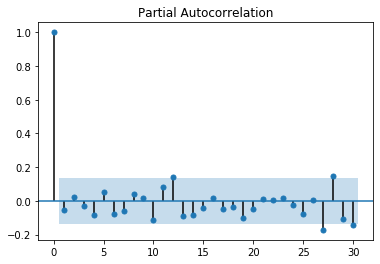

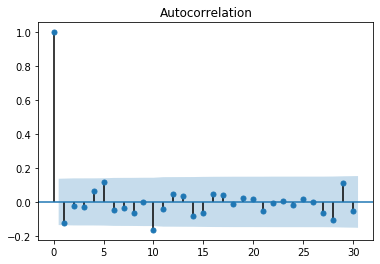

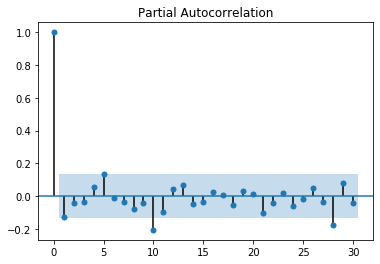

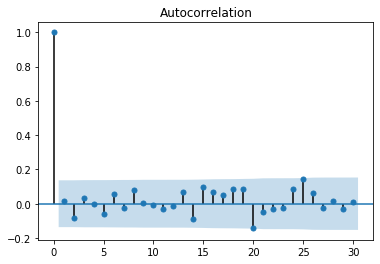

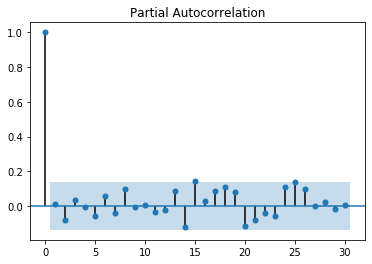

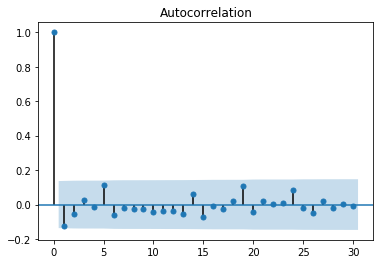

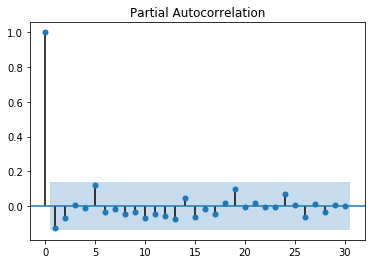

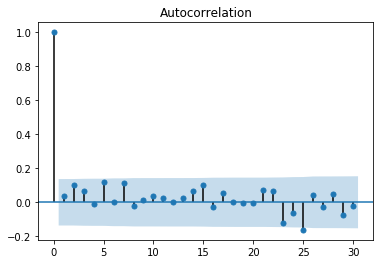

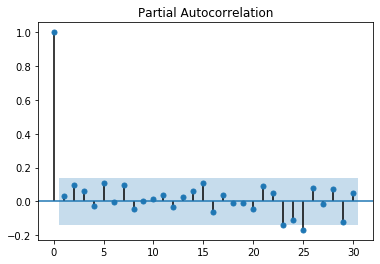

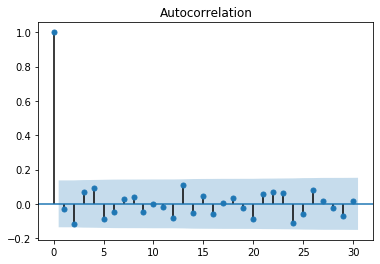

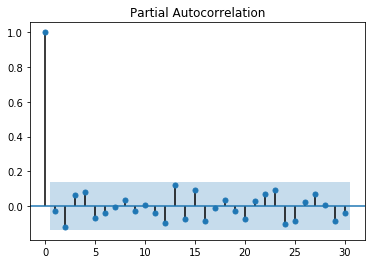

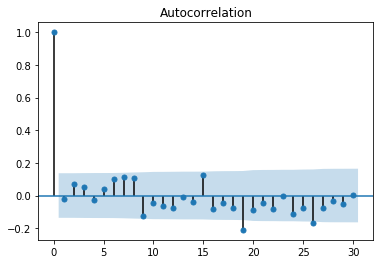

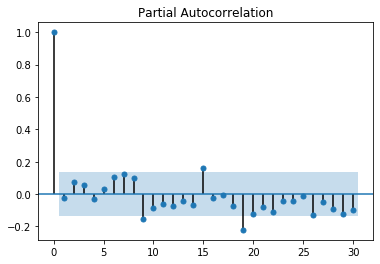

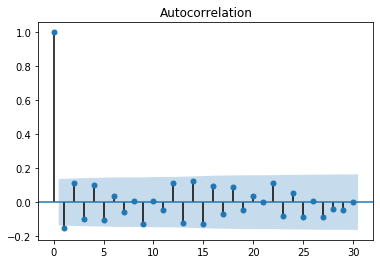

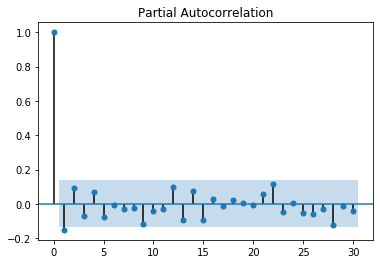

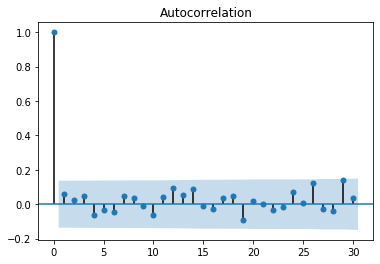

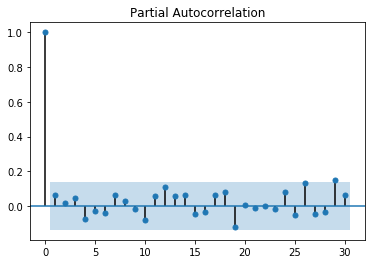

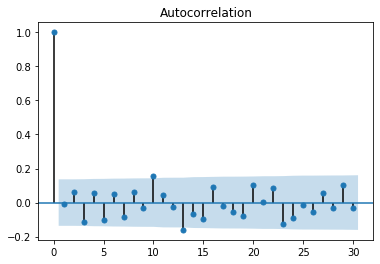

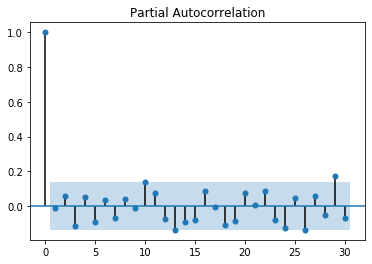

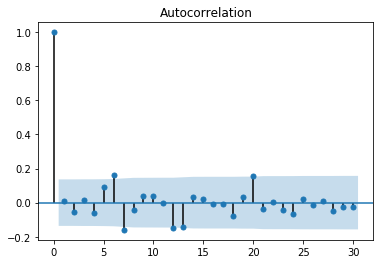

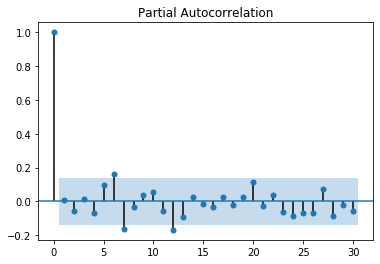

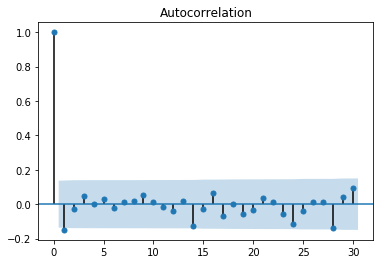

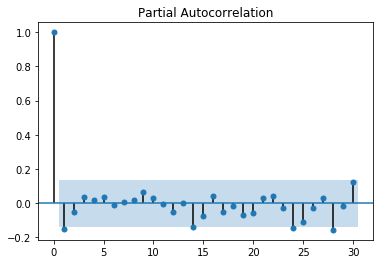

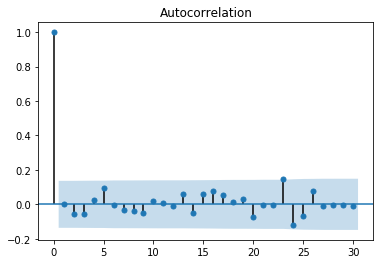

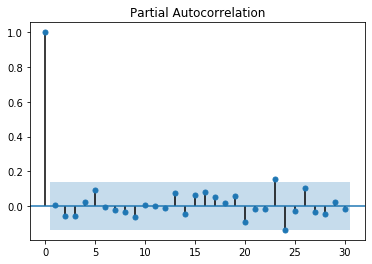

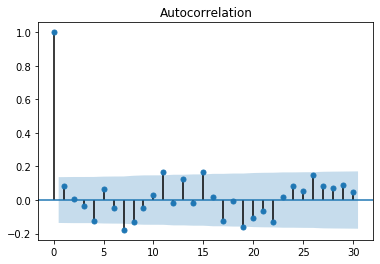

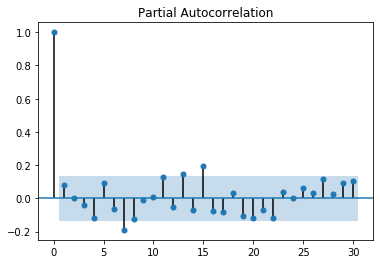

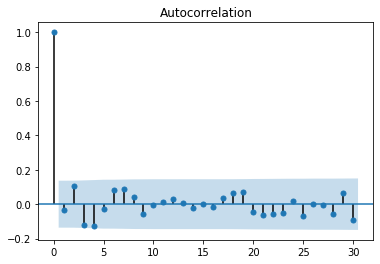

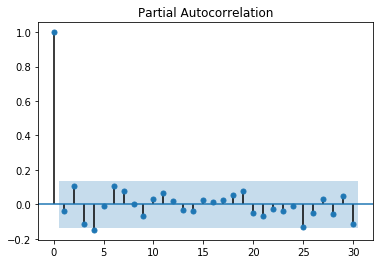

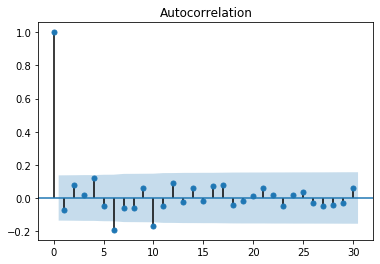

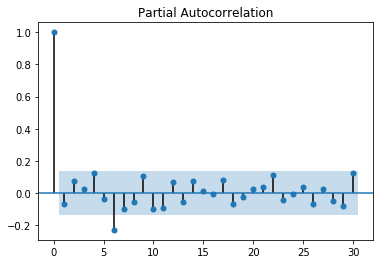

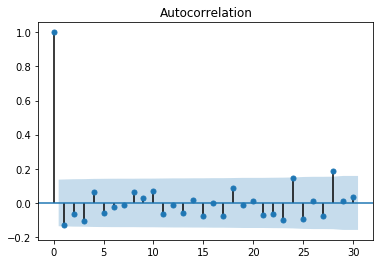

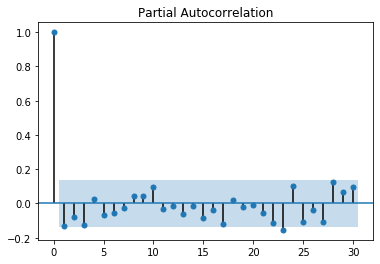

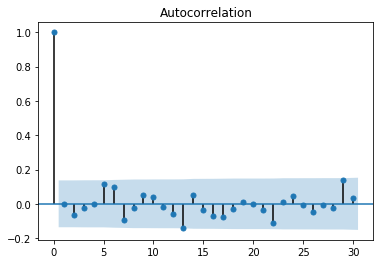

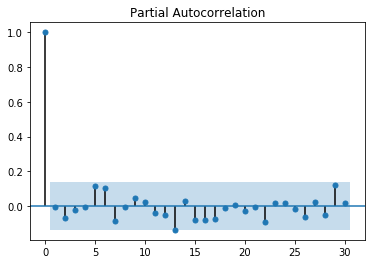

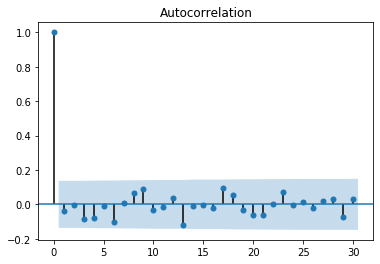

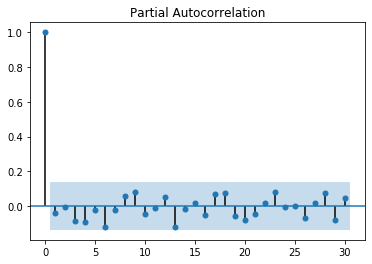

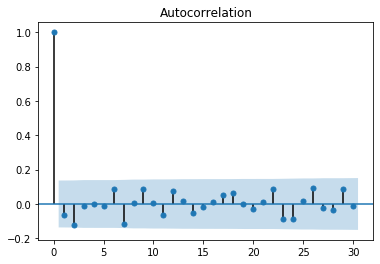

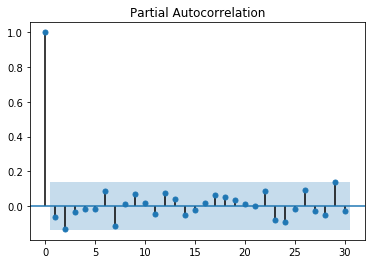

In [14]:
# Preprocess training data
possibleNotes = np.unique(tr_notes)
k = len(possibleNotes)
xNotes = encode(tr_notes, possibleNotes)
n = len(xNotes)


number_of_states = [10,20,30]
names=['hmm10','hmm20','hmm30']

for j in range(len(names)):
    model = hmm.MultinomialHMM(n_components=number_of_states[j])

    observ_data = xNotes.reshape(len(xNotes),1)
    model.fit(observ_data)
    results = model.predict(observ_data)
    transition_matrix = model.transmat_
    emission_matrix = model.emissionprob_
    initial = model.startprob_

    it = 10

    m_list=[]
    print(names[j])
    for i in range(it):
        newNotes,z = sample_hmm(len(notes_template),initial,emission_matrix,transition_matrix,None,None,possibleNotes,'first_order')
        newVelocities = find_vel(newNotes, velocity, gp = True)
        metrics = calc_metrics(time, notes_template, newNotes, newVelocities, measures, min_note, num)
        m_list.append(metrics)
        
    Metrics[names[j]]= m_list

## Output music

In [14]:
import matplotlib.pyplot as plt

newNotes,z = sample_hmm(len(notes_template),initial,emission_matrix,transition_matrix,None,None,possibleNotes,'first_order')
newVelocities = find_vel(newNotes, velocity, gp = True)

len(newNotes)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


206

In [15]:
output_filename = dir_path+fname+'_hmm'+str(number_of_states)+'.csv'
print(output_filename)
song.iloc[ind, 1] = time
song.iloc[ind, 4] = newNotes
song.iloc[ind, 5] = newVelocities
song.iloc[ind[np.where(newVelocities !=0)], 2] = ' Note_on_c'
song.iloc[ind[np.where(newVelocities ==0)], 2] = ' Note_off_c'
split = output_filename.split('.')
song.to_csv(output_filename, header = None, index = False)

/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/results/13Alleinzudir_hmm10.csv


In [17]:
!csvmidi /Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/results/13Alleinzudir_hmm10.csv /Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/results/13Alleinzudir_hmm10.mid

csvmidi: Error on line 4:
    1, 0, Key_signature, 0," ""major""",,
  Field 5 has invalid major/minor indicator " "major"".
csvmidi: Error on line 7:
    1, 4096, Key_signature, 0," ""major""",,
  Field 5 has invalid major/minor indicator " "major"".
csvmidi: Error on line 9:
    1, 8192, Key_signature, 0," ""major""",,
  Field 5 has invalid major/minor indicator " "major"".
csvmidi: Error on line 11:
    1, 12288, Key_signature, 0," ""major""",,
  Field 5 has invalid major/minor indicator " "major"".
csvmidi: Error on line 13:
    1, 16384, Key_signature, 0," ""major""",,
  Field 5 has invalid major/minor indicator " "major"".
csvmidi: Error on line 15:
    1, 20480, Key_signature, 0," ""major""",,
  Field 5 has invalid major/minor indicator " "major"".
csvmidi: Error on line 17:
    1, 24576, Key_signature, 0," ""major""",,
  Field 5 has invalid major/minor indicator " "major"".
csvmidi: Error on line 19:
    1, 28672, Key_signature, 0," ""major""",,
  Field 5 has invalid major/minor

In [22]:
import pretty_midi
import numpy as np
# For plotting
import mir_eval.display
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
# For putting audio in the notebook
import IPython.display
def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))

In [23]:
pm = pretty_midi.PrettyMIDI('/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/results/13Alleinzudir_hmm10.mid')

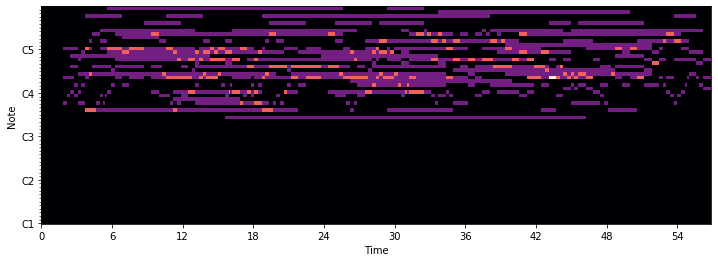

In [24]:
plt.figure(figsize=(12, 4))
plot_piano_roll(pm, 24, 84)

In [130]:
IPython.display.Audio(pm.synthesize(fs=16000),rate=16000)

## Evalutaion

<Figure size 432x288 with 0 Axes>

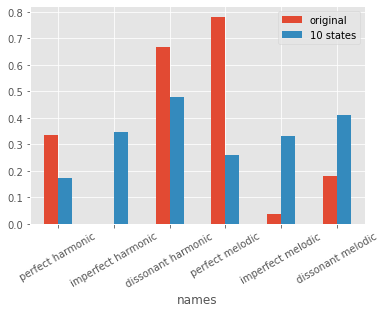

0         1
names                                 
perfect harmonic    0.333333  0.173669
imperfect harmonic  0.000000  0.347339
dissonant harmonic  0.666667  0.478992
perfect melodic     0.780952  0.260813
imperfect melodic   0.038095  0.330275
dissonant melodic   0.180952  0.408912

In [136]:
##        percentage is a vector of length 6 containing the percentage of perfect harmonic intervals, the percentage of imperfect 
##           consonant harmonic intervals, the percentage of dissonant harmonic intervals, the percentage of perfect melodic
##           intervals, the percentage of imperfect consonant melodic intervals and the percentage of dissonant melodic intervals      
import matplotlib
matplotlib.style.use('ggplot')
#a=np.array([orig_metrics[2],metrics_5[2],metrics_10[2],metrics_15[2]]).reshape(6,4)
df = pd.DataFrame([orig_metrics[2],metrics_10[2]])
df=df.T
df['names'] = ['perfect harmonic','imperfect harmonic','dissonant harmonic','perfect melodic','imperfect melodic','dissonant melodic']
df.set_index('names',inplace=True)
plt.figure()

df.plot(kind='bar',rot=30)
plt.legend(['original','10 states'])
plt.show()

df

# Two-layered HMM

### Fitting and  Outputing evaluation metrics

10


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)


lhmm10


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become 

20


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)


lhmm20


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/graphics/utils.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.fra

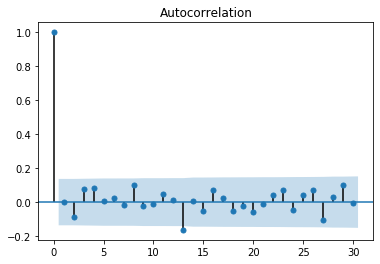

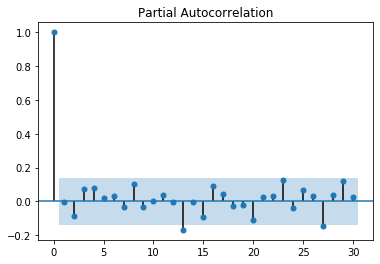

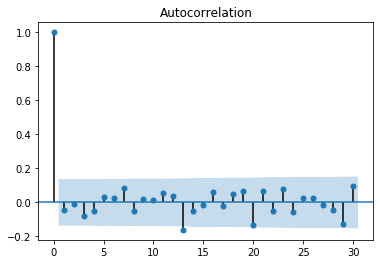

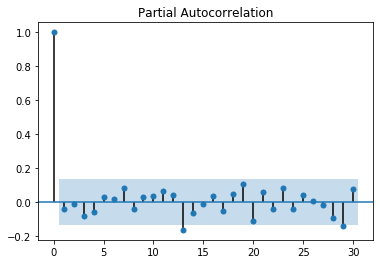

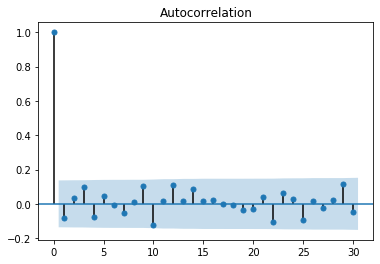

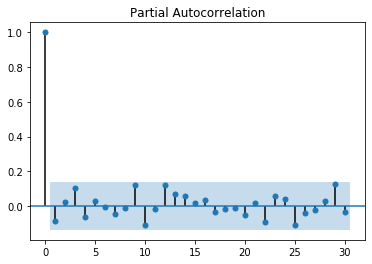

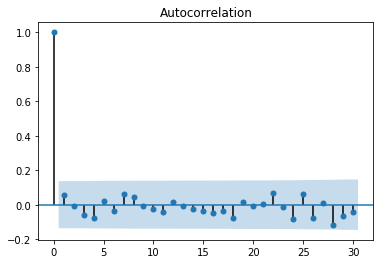

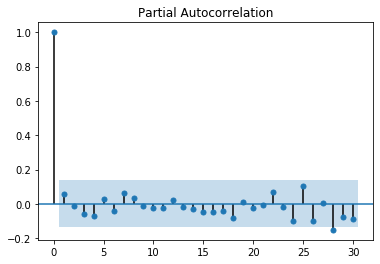

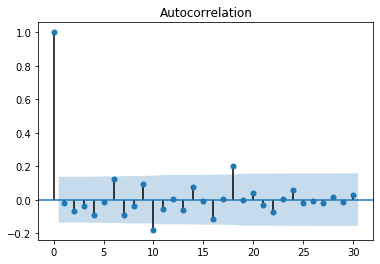

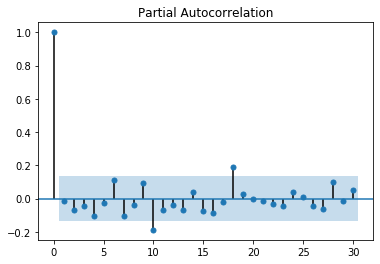

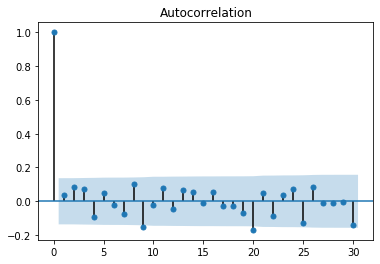

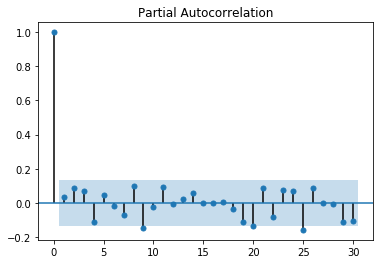

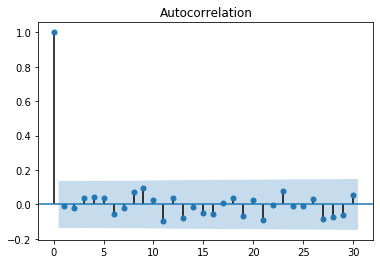

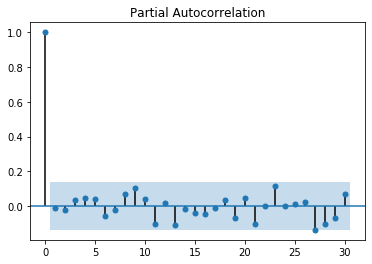

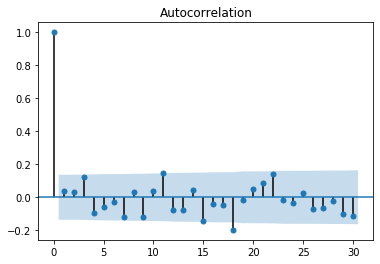

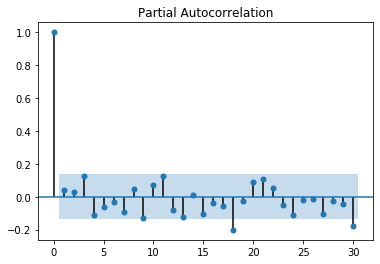

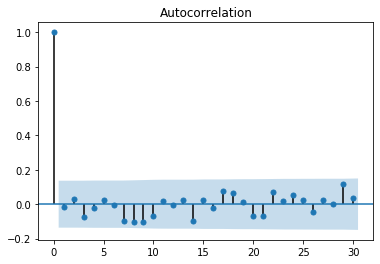

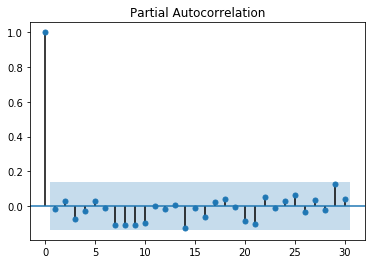

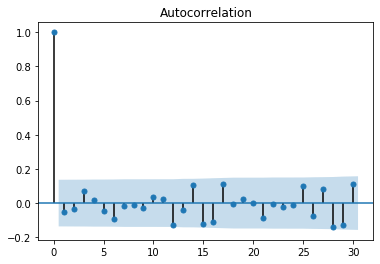

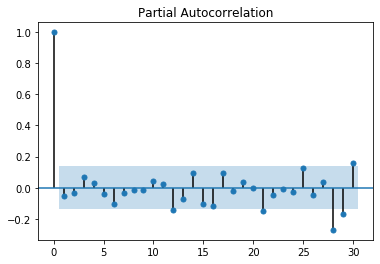

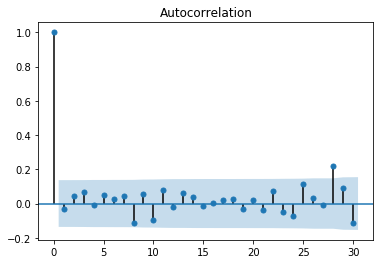

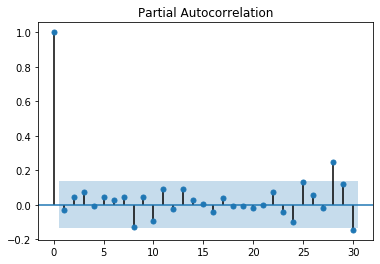

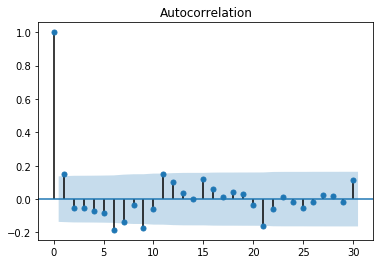

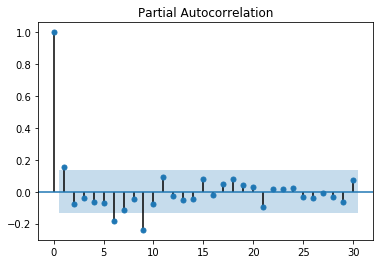

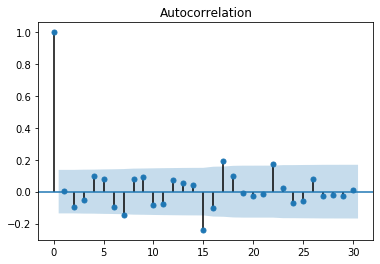

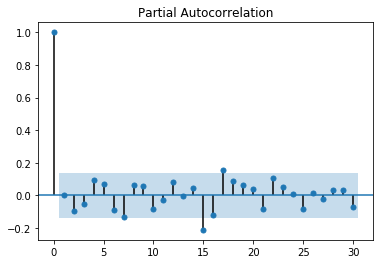

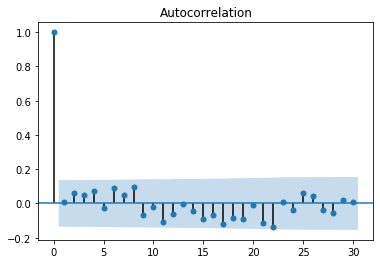

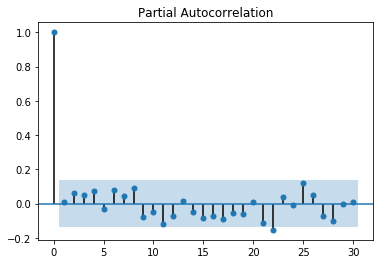

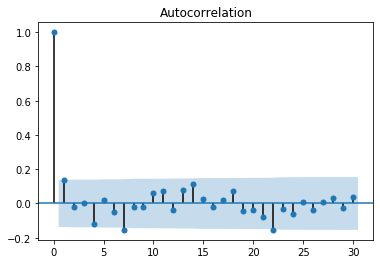

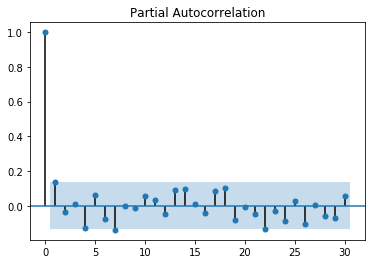

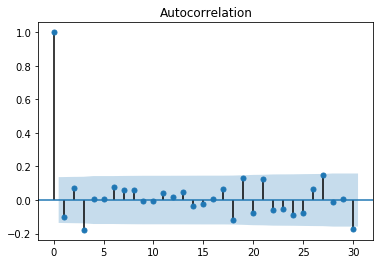

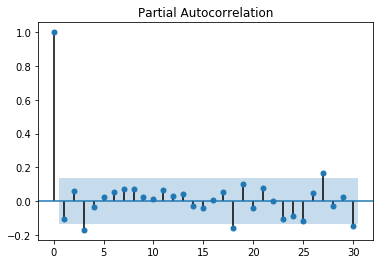

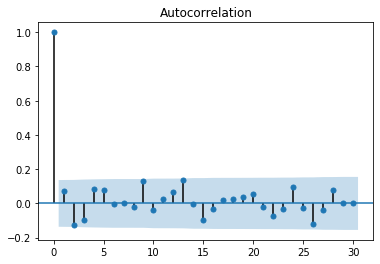

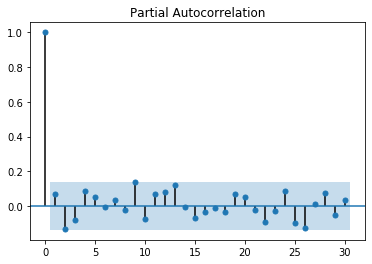

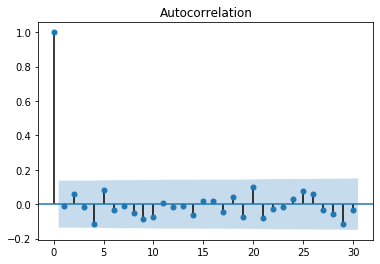

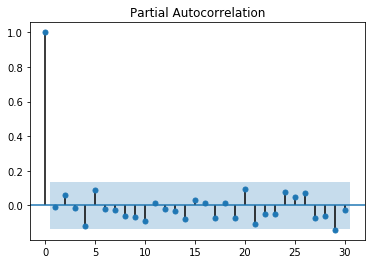

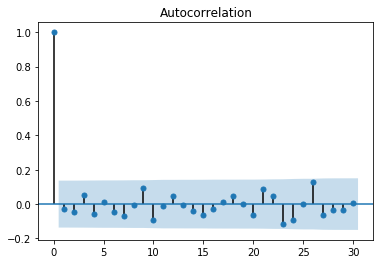

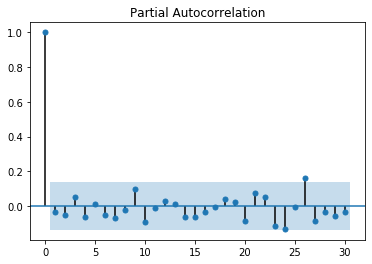

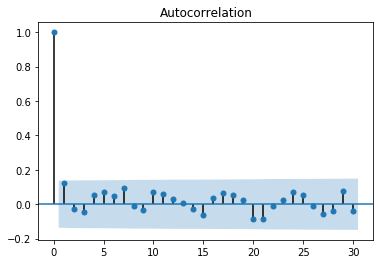

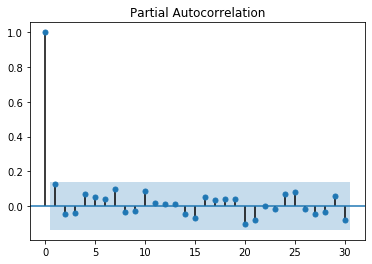

In [16]:
from BaumWelch import *

# NUMBER OF HIDDEN STATES

m = [10,20]
names=['lhmm10','lhmm20']


for t in range(len(m)):
    print(m[t])
    model1 = hmm.MultinomialHMM(n_components=m[t])
    observ_data = xNotes.reshape(len(xNotes),1)
    model1.fit(observ_data)
    results = model1.predict(observ_data)
    Tmat1 = model1.transmat_
    phi1 = model1.emissionprob_
    pi1 = model1.startprob_
    
    zStar1 = Viterbi(n, m[t], k, np.log(pi1), np.log(Tmat1), np.log(phi1), xNotes)
    zStar1 = np.array(zStar1).astype(int)

    model2 = hmm.MultinomialHMM(n_components=m[t])
    observ_data = zStar1.reshape(len(zStar1),1)
    model2.fit(observ_data)
    results = model2.predict(observ_data)
    Tmat2 = model2.transmat_
    phi2 = model2.emissionprob_
    pi2 = model2.startprob_
    

    zStar2 = Viterbi(n, m[t], m[t], np.log(pi2), np.log(Tmat2), np.log(phi2), zStar1)
    zStar2 = np.array(zStar2).astype(int)
    
    z = [zStar1, zStar2]
    
    # Evaluation 
    it =10
    print(names[t])
    m_list=[]
    for i in range(it):
        output = np.zeros(shape = (2,n), dtype = int)
        xstates = range(0, k)
        zstates = range(0, m[t])
        for j in range(0,n):
            output[1, j] = np.random.choice(zstates, size = 1, p = phi2[zStar2[j], :])
            #print(phi1_saved.shape)
            output[0, j] = np.random.choice(xstates, size = 1, p = phi1[output[1, j], :])
            
        temp_notes = decode(output[0,:], possibleNotes).astype(int)
        newNotes = temp_notes
        newNotes = newNotes[:len(notes_template)]
        newVelocities = find_vel(newNotes, velocity,False)
        metrics = calc_metrics(time, notes_template, newNotes, newVelocities, measures, min_note, num)
        m_list.append(metrics)
        
    Metrics[names[t]]=m_list

# Output Music

In [191]:
output_filename = dir_path+fname+'_lhmm'+str(m)+'.csv'
print(output_filename)
song.iloc[ind, 1] = time
song.iloc[ind, 4] = newNotes
song.iloc[ind, 5] = newVelocities
song.iloc[ind[np.where(newVelocities !=0)], 2] = ' Note_on_c'
song.iloc[ind[np.where(newVelocities ==0)], 2] = ' Note_off_c'
split = output_filename.split('.')
song.to_csv(output_filename, header = None, index = False)

# AR+Layered HMM

In [93]:
def ARViterbi(x,num_unique_states,initial_states_vector,transition_matrix,phi,psi):
    """
    Auxiliary method that uses Viterbi on single chain
    @param X: array-like with dimension [ # of length]
    @return z: array-like with dimension [# of length]
    """
    # init holders
    z = []
    V = np.zeros( (len(x), num_unique_states) )
    best_states = np.zeros( (len(x), num_unique_states) )

    #########################################
    # TODO: implement the Viterbi algorithm #
    #########################################

    for i in range(len(x)): 
        for j in range(num_unique_states):
            #print(psi[j,x[i],x[i-1]])
            if i == 0:                
                all_path_to_j_state = np.log(phi[j,x[i]]*initial_states_vector)
                #print(all_path_to_j_state)
                #print(phi[j,x[i]])
            else:                                   
                all_path_to_j_state = np.log(psi[j,x[i],x[i-1]])+V[i-1,:]+np.log(transition_matrix[:,j]) 
            #print(all_path_to_j_state)
            best_states[i,j] = np.argmax(all_path_to_j_state)
            print(best_states[i,j])
            V[i,j] = all_path_to_j_state[int(best_states[i,j])]
            #print(best_states[i,j])                    
    print(best_states)    
        
    best_possible_seq = np.zeros(len(x))

    for i in range(len(x)-1,-1,-1):            
        if i == len(x)-1:                
            best_possible_seq[i] = int(np.argmax(V[i]))
        else:
            best_possible_seq[i] = best_states[i+1,int(best_possible_seq[i+1])]

    return best_possible_seq

In [94]:
def Viterbi2(n, m, k, pi, Tmat,phi, x, psi):
    f = np.zeros(shape = (n,m))
    alpha = np.zeros(shape = (n,m))
    zStar = np.zeros(n)
    
    for t in range(0, n):
        for i in range(0,m):
            if t == 0:
                f[0, i] = pi[i] + phi[i, x[0]]
            else:
                #print(f[t-1, :].shape,Tmat[:, i].shape,psi[i, x[t], x[t-1]].shape)
                u = np.asarray(f[t-1, :]) + np.asarray(Tmat[:, i]) + psi[i, x[t], x[t-1]]
                
                f[t,i] = np.max(u)
                alpha[t,i] = np.argmax(u)
    zStar[n-1] = np.argmax(np.asarray(f[n-1, :]))
    for i in range(n-2, -1, -1):
        zStar[i] = alpha[i+1, int(zStar[i+1])]
    return zStar

In [95]:
def hmmARHMM(n, pi, phi, Tmat, psi, code):
    m = Tmat.shape[0]
    k = phi.shape[1]
    zstates = np.arange(0, m)
    xstates = np.arange(0, k)
    z = np.zeros(n, dtype = int)
    x = np.zeros(n, dtype = int)
    z[0] = np.random.choice(zstates, size = 1, p = pi)
    x[0] = np.random.choice(xstates, size = 1, p = phi[z[0], :])
    
    for j in range(1, n):
        z[j] = np.random.choice(zstates, size = 1, p = Tmat[z[j-1], :])
    for i in range(0, n):
        x[i] = np.random.choice(xstates, size = 1, p = psi[z[i], :, x[i-1]])
    output = decode(x, code)
    return(output, z)

In [212]:
possibleNotes = np.unique(notes_template)
k = len(possibleNotes)
xNotes = encode(notes_template, possibleNotes)
n = len(xNotes)

m = 5

it1, p1, pi1, phi1, Tmat1 = first_order(n, m, k, xNotes, tol)
it2, p2, psi = first_orderARHMM(n, m, k, np.log(pi1), np.log(Tmat1), np.log(phi1), xNotes,  tol)
newNotes,z  = hmmARHMM(n, pi1, phi1, Tmat1, psi, possibleNotes)
print(psi.shape)
# print(newNotes)

#it1, p1, pi1, phi1, Tmat1 = first_order(n, m, k, xNotes, tol)
zStar1 = Viterbi2(n, m, m, np.log(pi1), np.log(Tmat1), np.log(phi1), zStar1,np.log(psi))
zStar1 = np.array(zStar1).astype(int)

it2, p2, pi2, phi2, Tmat2 = first_order(n, m, m, zStar1, tol)
zStar2 = Viterbi(n, m, m, np.log(pi2), np.log(Tmat2), np.log(phi2), zStar1)
zStar2 = np.array(zStar2).astype(int)
# it3, p3, pi3, phi3, Tmat3 = first_order(n, m, m, zStar2, tol)
# zStar3 = Viterbi(n, m, m, np.log(pi3), np.log(Tmat3), np.log(phi3), zStar2)
# zStar3 = np.array(zStar3).astype(int)


output = np.zeros(shape = (2,n), dtype = int)
xstates = range(0, k)
zstates = range(0, m)
#for i in range(it):
for j in range(0,n):
#   output[2, j] = np.random.choice(zstates, size = 1, p = phi3[zStar3[j], :])
    output[1, j] = np.random.choice(zstates, size = 1, p = phi2[zStar2[j], :])
    output[0, j] = np.random.choice(xstates, size = 1, p = phi1[output[1, j], :])
temp_notes = decode(output[0,:], possibleNotes).astype(int)
newNotes = temp_notes
newVelocities = find_vel(newNotes, velocity,False)
#     if metrics_calc:
#         metrics[i+1, :] = calc_metrics(time, notes, newNotes, newVelocities, measures, min_note, num)
phi1 = [phi1, phi2]




1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


1
(5, 20, 20)
1


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


In [125]:

m = [5]
names = ['arhmm10','arhmm10']

tol =0.01
#xNotes1=xNotes[:5000]
for t in range(len(m)):
    
    model1 = hmm.MultinomialHMM(n_components=m[t])
    observ_data = xNotes.reshape(len(xNotes),1)
    model1.fit(observ_data)
    results = model1.predict(observ_data)
    Tmat1 = model1.transmat_
    phi1 = model1.emissionprob_
    pi1 = model1.startprob_
    
#    it1, p1, pi1, phi1, Tmat1 = first_order(n, m[t], k, xNotes, tol)
    it2, p2, psi = first_orderARHMM(n, m[t], k, np.log(pi1), np.log(Tmat1), np.log(phi1), xNotes,  tol)
    newNotes,z  = hmmARHMM(n, pi1, phi1, Tmat1, psi, possibleNotes)
 
    zStar1 = Viterbi2(n, m[t], m[t], np.log(pi1), np.log(Tmat1), np.log(phi1), zStar1,np.log(psi))
    zStar1 = np.array(zStar1).astype(int)

#     model2 = hmm.MultinomialHMM(n_components=m[t])
#     observ_data = zStar1.reshape(len(zStar1),1)
#     model2.fit(observ_data)
#     results = model2.predict(observ_data)
#     Tmat2 = model2.transmat_
#     phi2 = model2.emissionprob_
#     pi2 = model2.startprob_

#     model2 = hmm.MultinomialHMM(n_components=m[t])
#     observ_data = zStar1.reshape(len(zStar1),1)
#     model2.fit(observ_data)
#     results = model2.predict(observ_data)
#     Tmat2 = model2.transmat_
#     phi2 = model2.emissionprob_
#     pi2 = model2.startprob_
#     print(phi2.shape)
    
    it2, p2, pi2, phi2, Tmat2 = first_order(n, m[t], m[t], zStar1, tol)
    zStar2 = Viterbi(n, m[t], m[t], np.log(pi2), np.log(Tmat2), np.log(phi2), zStar1)
    zStar2 = np.array(zStar2).astype(int)
    
   
    # Evaluation 
    it =10
    #print(names[t])
    m_list=[]
    for i in range(it):
        output = np.zeros(shape = (2,n), dtype = int)
        xstates = range(0, k)
        zstates = range(0, m[t])

        for j in range(0,n):
            print(phi2.shape)
            output[1, j] = np.random.choice(zstates, size = 1, p = phi2[zStar2[j], :])
            
            output[0, j] = np.random.choice(xstates, size = 1, p = phi1[output[1, j], :])
        temp_notes = decode(output[0,:], possibleNotes).astype(int)
        newNotes = temp_notes
        newVelocities = find_vel(newNotes, velocity,False)
        metrics = calc_metrics(time, notes_template, newNotes, newVelocities, measures, min_note, num)
        m_list.append(metrics)
        
    Metrics[names[t]]= m_list

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)


TypeError: only size-1 arrays can be converted to Python scalars

arhmm5


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become 

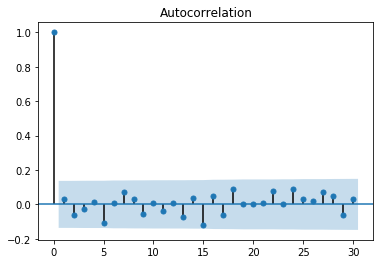

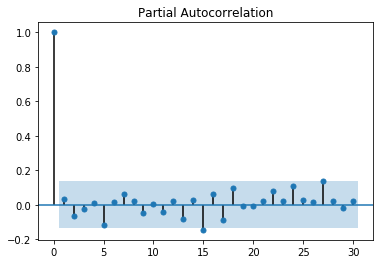

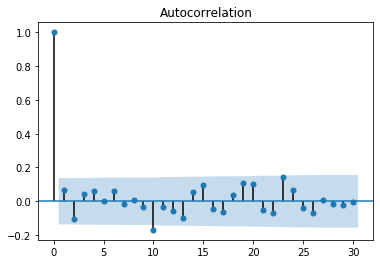

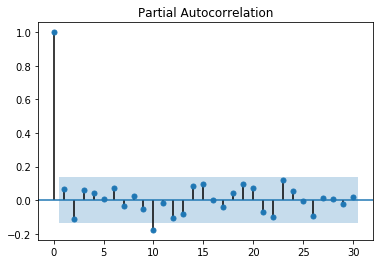

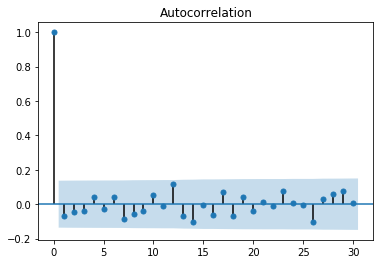

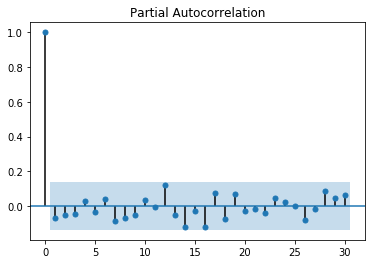

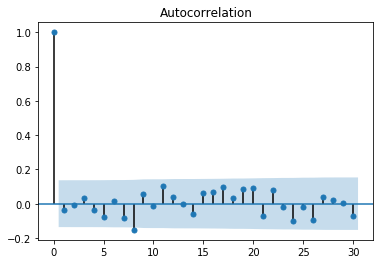

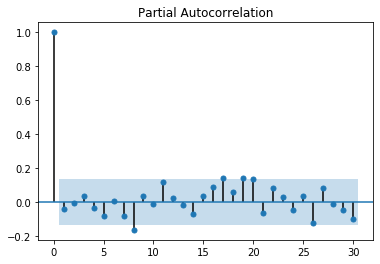

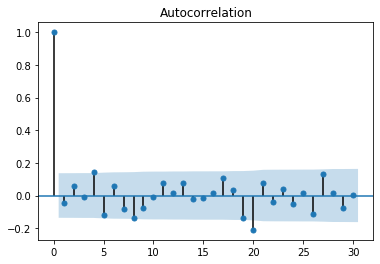

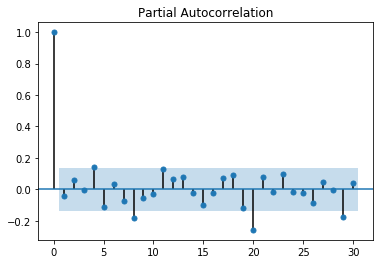

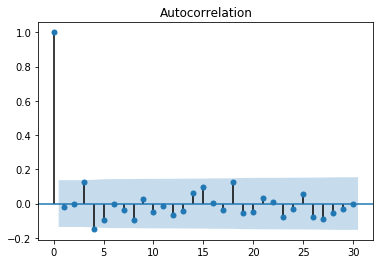

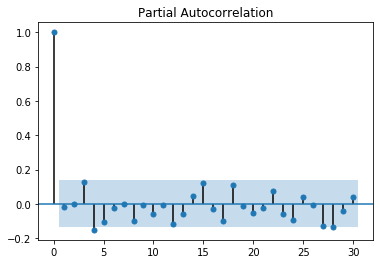

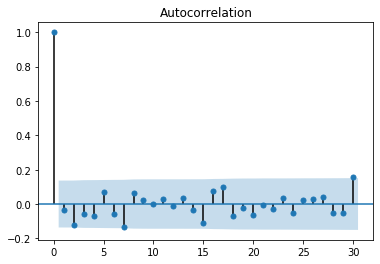

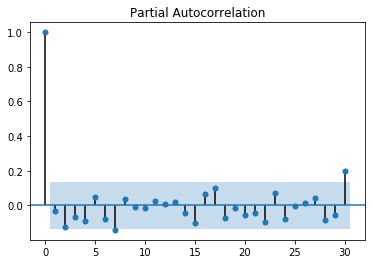

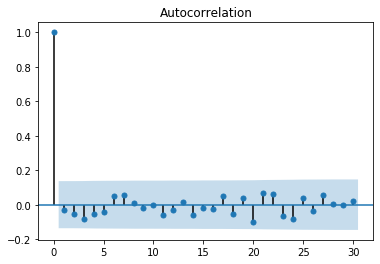

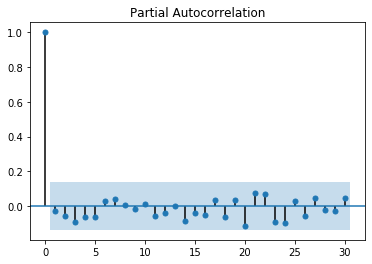

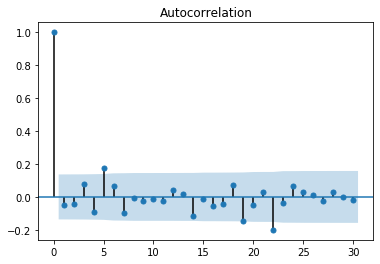

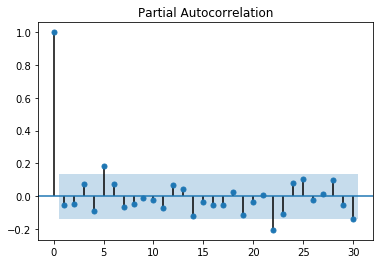

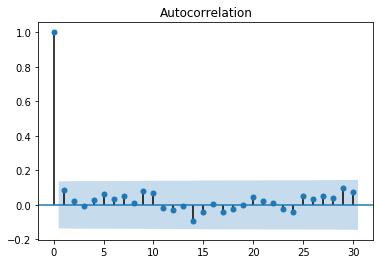

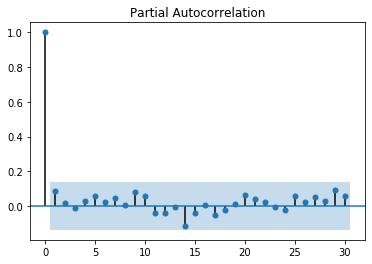

In [111]:

# Evaluation 
it =10
print(names[t])
m_list=[]
for i in range(it):
    output = np.zeros(shape = (2,n), dtype = int)
    xstates = range(0, k)
    zstates = range(0, m[t])

    for j in range(0,n):
        #print(phi2.shape)
        output[1, j] = np.random.choice(zstates, size = 1, p = phi2[zStar2[j], :])

        output[0, j] = np.random.choice(xstates, size = 1, p = phi1[output[1, j], :])
    temp_notes = decode(output[0,:], possibleNotes).astype(int)
    newNotes = temp_notes
    newVelocities = find_vel(newNotes, velocity,False)
    metrics = calc_metrics(time, newNotes[:206], newNotes[:206], newVelocities, measures, min_note, num)
    m_list.append(metrics)

Metrics[names[t]]= m_list

## Output music 

In [200]:
output_filename = '/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/results/greensleeves_hmm_arlhmm.csv'
song.iloc[ind, 1] = time
song.iloc[ind, 4] = newNotes
song.iloc[ind, 5] = newVelocities
song.iloc[ind[np.where(newVelocities !=0)], 2] = ' Note_on_c'
song.iloc[ind[np.where(newVelocities ==0)], 2] = ' Note_off_c'
split = output_filename.split('.')
song.to_csv(output_filename, header = None, index = False)

In [118]:
pd.set_option('display.max_rows', 500)
display(song)

0       1                2                              3         4  \
0    0       0           Header                              1         2   
1    1       0      Start_track                           None      None   
2    1       0   Time_signature                              4         2   
3    1       0    Key_signature                              0   "major"   
4    1       0            Tempo                         600000      None   
5    1       0          Title_t   "Twinke Twinkle Little Star"      None   
6    1       0           Text_t                        "trad."      None   
7    1       1        End_track                           None      None   
8    2       0      Start_track                           None      None   
9    2       0        Program_c                              0         0   
10   2       0        Control_c                              0       121   
11   2       0        Control_c                              0        64   
12   2       0        Control_c                              0        91   
13   2       0        Control_c                              0        10   
14   2       0        Control_c                              0         7   
15   2       0        Note_on_c                              0        64   
16   2       0        Control_c                              0       121   
17   2       0        Control_c                              0        64   
18   2       0        Control_c                              0        91   
19   2       0        Control_c                              0        10   
20   2       0        Control_c                              0         7   
21   2       0        Note_on_c                              0        52   
22   2     960        Note_on_c                              0        65   
23   2     960        Note_on_c                              0        60   
24   2    1920        Note_on_c                              0        48   
25   2    1920        Note_on_c                              0        53   
26   2    1920       Note_off_c                              0        53   
27   2    1920        Note_on_c                              0        50   
28   2    2880        Note_on_c                              0        53   
29   2    2880       Note_off_c                              0        53   
30   2    3840       Note_off_c                              0        65   
31   2    3840        Note_on_c                              0        69   
32   2    3840       Note_off_c                              0        48   
33   2    3840       Note_off_c                              0        50   
34   2    4800        Note_on_c                              0        48   
35   2    4800        Note_on_c                              0        65   
36   2    5760        Note_on_c                              0        53   
37   2    5760       Note_off_c                              0        69   
38   2    5760        Note_on_c                              0        55   
39   2    5760        Note_on_c                              0        50   
40   2    7680        Note_on_c                              0        69   
41   2    7680       Note_off_c                              0        48   
42   2    7680       Note_off_c                              0        69   
43   2    7680       Note_off_c                              0        53   
44   2    8640        Note_on_c                              0        48   
45   2    8640       Note_off_c                              0        48   
46   2    9600        Note_on_c                              0        53   
47   2    9600        Note_on_c                              0        69   
48   2    9600       Note_off_c                              0        55   
49   2    9600        Note_on_c                              0        55   
50   2   10560       Note_off_c                              0        53   
51   2   10560        Note_on_c                      

<Figure size 432x288 with 0 Axes>

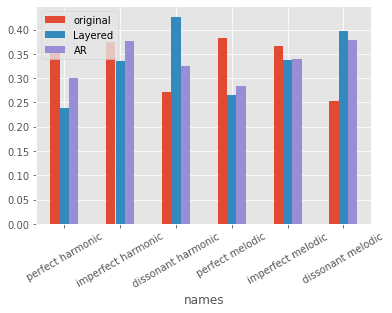

0         1         2
names                                           
perfect harmonic    0.353659  0.238095  0.300000
imperfect harmonic  0.373984  0.335601  0.375610
dissonant harmonic  0.272358  0.426304  0.324390
perfect melodic     0.382208  0.265987  0.283333
imperfect melodic   0.365733  0.337349  0.338542
dissonant melodic   0.252059  0.396664  0.378125

In [198]:
import matplotlib
matplotlib.style.use('ggplot')
#a=np.array([orig_metrics[2],metrics_5[2],metrics_10[2],metrics_15[2]]).reshape(6,4)
df = pd.DataFrame([orig_metrics[2],metrics_2layered[2],metrics_layer_ar[2]])
df=df.T
df['names'] = ['perfect harmonic','imperfect harmonic','dissonant harmonic','perfect melodic','imperfect melodic','dissonant melodic']
df.set_index('names',inplace=True)
plt.figure()

df.plot(kind='bar',rot=30)
plt.legend(['original','Layered','AR'])
plt.show()

df

In [17]:
class pre_process2(object):
    def __init__(self, input_filename, min_note):
        self.input_filename = input_filename
        self.min_note = min_note
      
    
    def read_process(self):
        with open(self.input_filename,encoding = "ISO-8859-1") as fd:
            reader=csv.reader(fd)
            rows= [row for idx, row in enumerate(reader)]
        song = pd.DataFrame(rows)
        r,c = np.where(song == ' Header')
        quarter_note = song.iloc[r,5].values.astype(int)[0]
        r, c = np.where(song == ' Time_signature')
        num = 4
        denom = 4
        try:
            r, c = np.where(song == ' Key_signature')
            key = song.iloc[r,3].values.astype(int)[0]
        except:
            key = None
        
        song_model = song.loc[song.iloc[:,0] == np.max(song.iloc[:,0])]
        song_model = song_model[song_model.iloc[:, 2].isin([' Note_on_c', ' Note_off_c'])]
        time = np.array(song_model.iloc[:,1]).astype(int)
        notes = np.array(song_model.iloc[:,4]).astype(int)
        velocity = np.array(song_model.iloc[:,5]).astype(int)
        measures = np.round(np.max(time)/quarter_note)/num
        min_note = quarter_note
        actual = np.arange(0, min_note*measures*num, min_note).astype(int) 
        time = np.array([find_nearest(actual, time[i]) for i in range(len(time))]).astype(int)
        return(quarter_note, num, denom, key, measures, time, notes, velocity, song, song_model.index)

/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/results/dmm_music/jsb-12.csv


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/results/dmm_music/jsb-11.csv


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/results/dmm_music/jsb-10.csv


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/results/dmm_music/jsb-14.csv


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/results/dmm_music/jsb-15.csv


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/results/dmm_music/jsb-16.csv


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/results/dmm_music/jsb-35.csv


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/results/dmm_music/jsb-46.csv


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/results/dmm_music/jsb-0.csv


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/results/dmm_music/jsb-1.csv


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


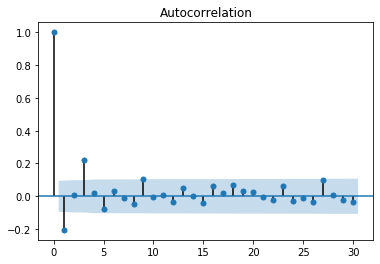

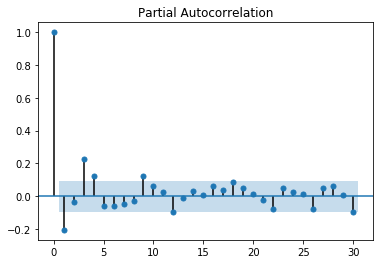

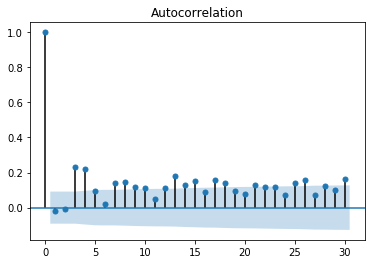

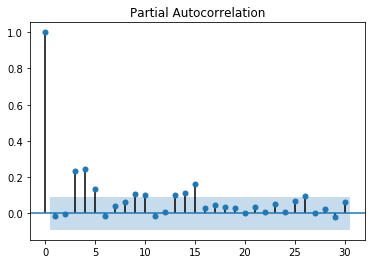

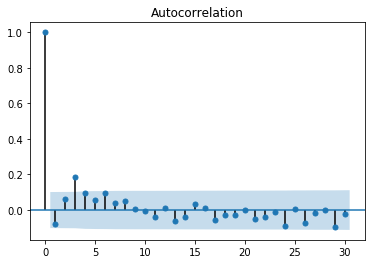

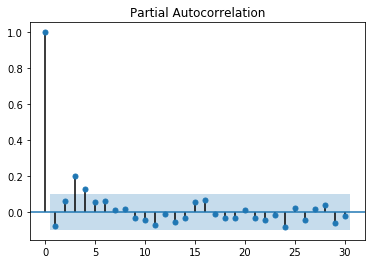

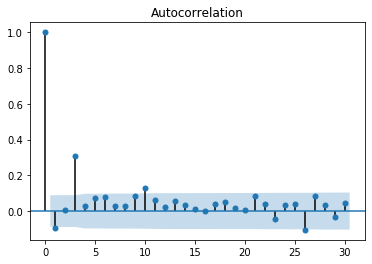

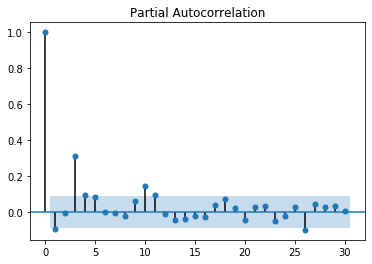

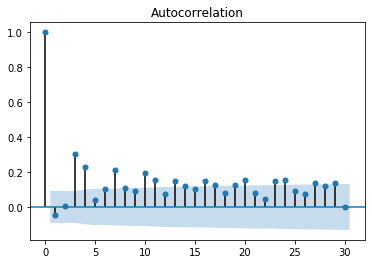

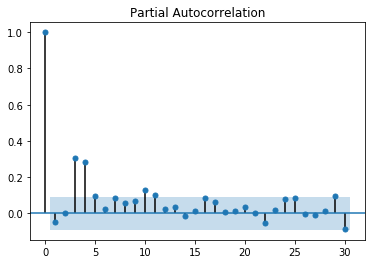

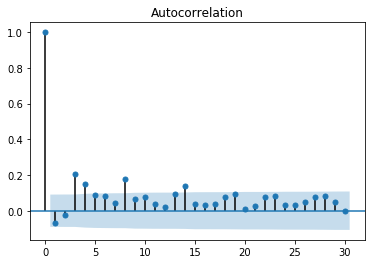

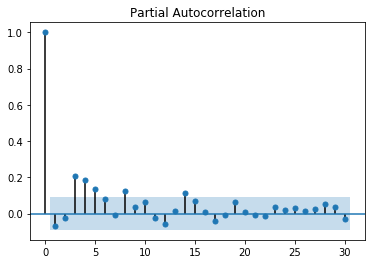

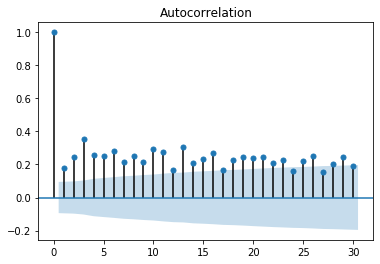

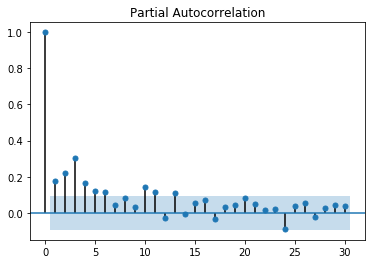

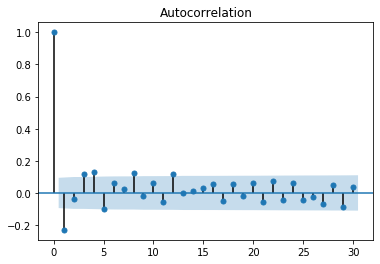

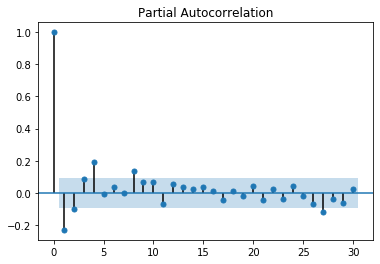

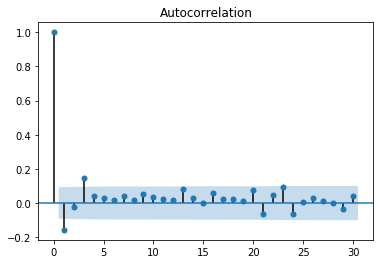

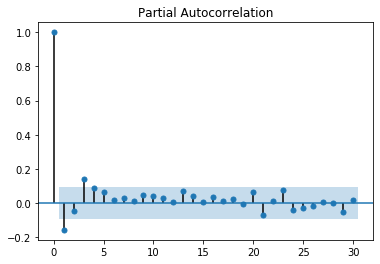

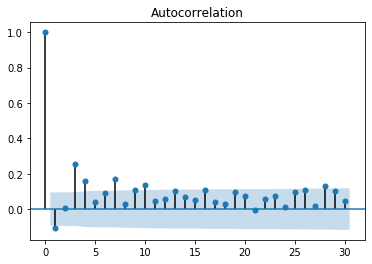

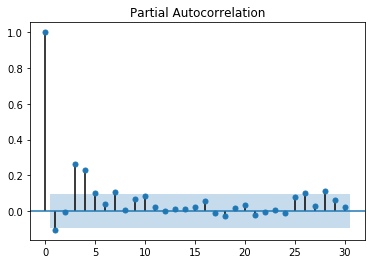

In [19]:
import glob

min_note = 1024
m_list=[]
for filepath in glob.iglob('/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/results/dmm_music/*.csv'):
    print(filepath)
#     dir_path = '/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/results/'
#     filepath = os.path.join(dir_path,fname+'.csv')
    music = pre_process2(filepath,min_note)

    quarter_note, num, denom, key, measures, time, \
            notes_template, velocity, song, ind = music.read_process()
    possibleVelocities =  np.unique(velocity)
    metrics = calc_metrics(time, notes_template, notes_template, velocity, measures, min_note, num)
    m_list.append(metrics)

Metrics['dmm'] = m_list

/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/results/10_bach/000707b_.csv


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/results/10_bach/000507b_.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/results/10_bach/000606b_.csv


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/results/10_bach/000907b_.csv


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/results/10_bach/000306b_.csv
/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/results/10_bach/000206b_.csv


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/results/10_bach/000806b_.csv


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/results/10_bach/000408b_.csv


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/results/10_bach/001207b_.csv


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/results/10_bach/001106b_.csv


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


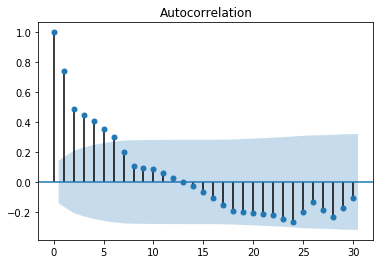

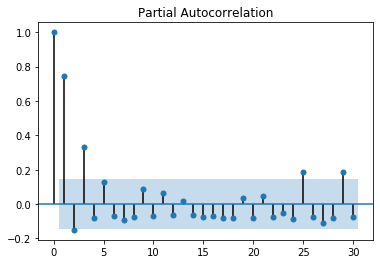

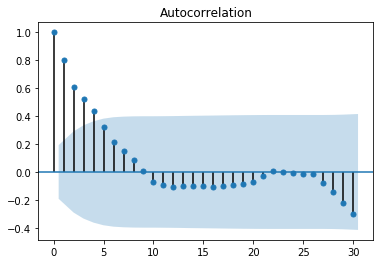

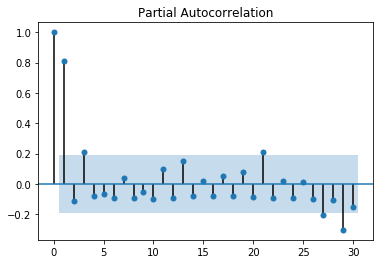

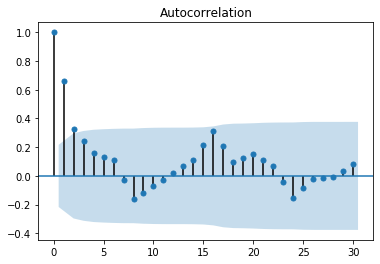

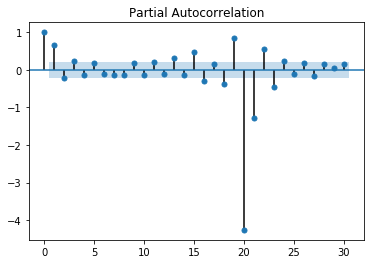

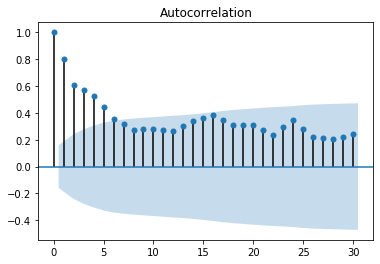

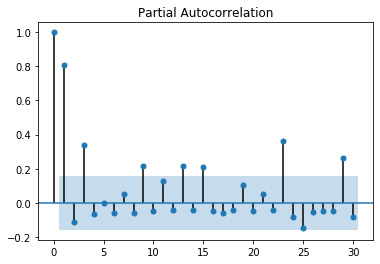

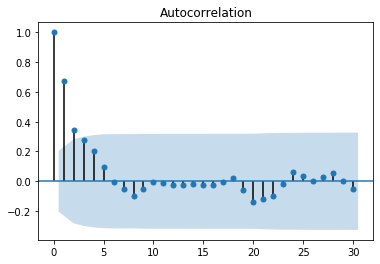

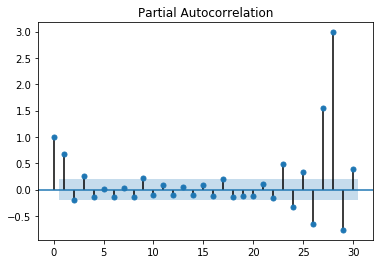

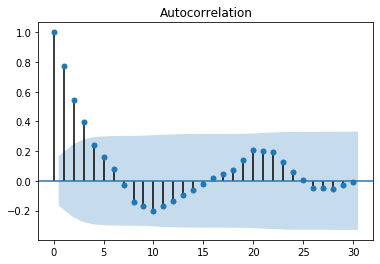

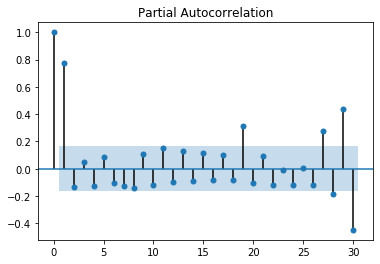

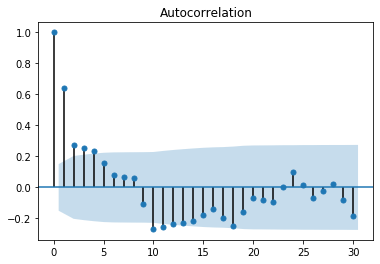

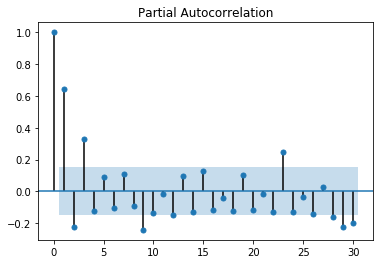

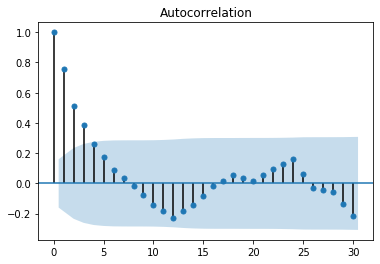

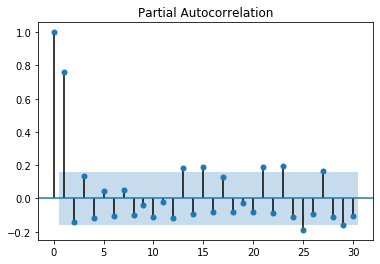

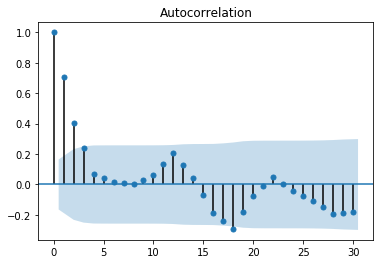

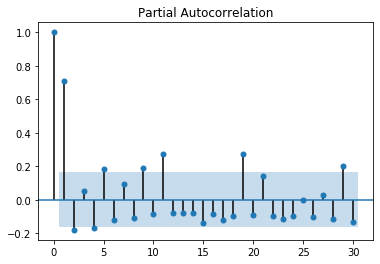

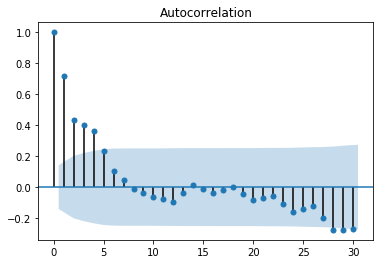

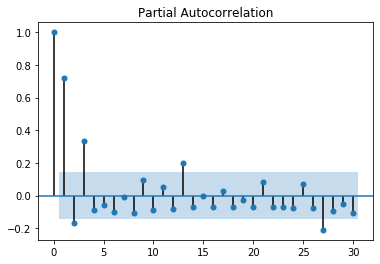

In [20]:
min_note = 1024
m_list=[]
for filepath in glob.iglob('/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/results/10_bach/*.csv'):
    print(filepath)
#     dir_path = '/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/results/'
#     filepath = os.path.join(dir_path,fname+'.csv')
    music = pre_process(filepath,min_note)

    quarter_note, num, denom, key, measures, time, \
            notes_template, velocity, song, ind = music.read_process()
    possibleVelocities =  np.unique(velocity)
    metrics = calc_metrics(time, notes_template, notes_template, velocity, measures, min_note, num)
    m_list.append(metrics)

Metrics['bach'] = m_list

In [162]:
av_Metrics={}
keys = Metrics.keys()
for i in keys:
    print(Metrics[i][0])
    #av_Metrics[i] = np.mean()

(array([ 0., 82., 82., 76., 65., 36., 40.,  3.,  4.,  1.,  0.,  0.]), array([84., 82., 83., 81., 84., 83., 84., 82., 82., 83., 82., 82.]), array([0.10025707, 0.37532134, 0.52442159, 0.25100806, 0.33266129,
       0.41633065]), array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00485437, 0.        , 0.00485437,
       0.        , 0.00485437, 0.00970874, 0.        , 0.00970874,
       0.00970874, 0.        , 0.        , 0.00970874, 0.06796117,
       0.02912621, 0.01456311, 0.03398058, 0.03883495, 0.00970874,
       0.09223301, 0.01456311, 0.01941748, 0.01456311, 0.03883495,
       0.05339806, 0.00485437, 0.07281553, 0.01941748, 0.03883495,
       0.05825243, 0.07281553, 0.02912621, 0.02427184, 0.01941748,
       0.02912621, 0.04368932, 0.02427184, 0.02427184, 0.02912621,
       0.00970874, 0.01941748]), array([ 1.        , -0.04532569, -0.08620328,  0.0280133 , -0.10413862,
       -0.01881479,  0.07624131,  0.08233841, -0.04365549,  0.042

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


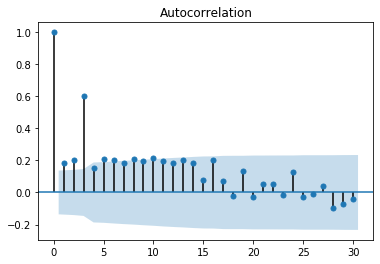

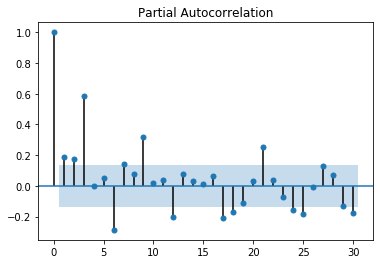

In [138]:
Metrics={}
filepath = '/Users/yanqixu/Documents/1.0.MasterCDS/DS3001/5.project/results/test_output.csv'
music = pre_process2(filepath,min_note)

quarter_note, num, denom, key, measures, time, \
        notes_template, velocity, song, ind = music.read_process()
possibleVelocities =  np.unique(velocity)
metrics = calc_metrics(time, notes_template[:206], notes_template[:206], velocity, measures, min_note, num)

Metrics['lstm']=[metrics]


In [141]:
m = Metrics.copy()
lis = m.keys()

In [144]:
m = Metrics.copy()
final={}
for i in lis:
    a1=[]
    for j in m[i]:
        b=[]
        for n in j:
            b.append(n.tolist())
                
        a1.append(b)
    final[i]=a1

In [145]:
import json
with open('result2.json', 'w') as fp:
    json.dump(final, fp)

In [120]:
final.keys()

dict_keys(['hmm10', 'hmm20', 'hmm30', 'lhmm10', 'lhmm20', 'dmm', 'bach', 'lstm', 'arhmm5'])